# Fase 3 - SVM con embeddings ItWac 32 (in-genre classification)
Sviluppare un classificatore basato su SVM lineari che prende in input una rappresentazione del testo costruita attraverso l’uso dei word embedding (http://www.italianlp.it/resources/italian-word-embeddings/). Riportare i seguenti risultati:
- testare diverse rappresentazioni del testo che variano rispetto al modo di combinare gli embedding delle singole parole e/o rispetto alle categorie grammaticali delle paroleprese in considerazione. Valutare i diversi sistemi con un processo di 5-fold cross validation condotto sul training set;
- valutazione sul test set ufficiale del miglior sistema rispetto ai risultati ottenuti con il processo di 5-fold cross validation del punto sopra.

Dal task GxG Evalita 2018:

"Given a (collection of) text(s) from a specific genre, the gender of the author has to be predicted. The task is cast as a binary classification task, with gender represented as F (female) or M (male). Gender prediction will be done in two ways: 

1. **using a model which has been trained on the same genre**
2. using a model which has been trained on anything but that genre."

In questo file utilizzeremo un modello allenato sullo stesso genere su cui poi verrà testato.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:

def load_word_embeddings(src_path):
    embeddings = dict()
    with open(src_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip().split('\t')
            word = line[0]
            embedding = [float(comp) for comp in line[1:]]
            embeddings[word] = np.asarray(embedding)
    return embeddings

def load_conllu_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    tokens, pos_tags = [], []
    for line in lines:
        if line.startswith('#') or line.strip() == '':
            continue
        parts = line.strip().split('\t')
        if '-' in parts[0] or '.' in parts[0]:
            continue
        tokens.append(parts[1].lower())
        pos_tags.append(parts[3])
    return tokens, pos_tags

def get_label_from_filename(filename):
    return filename.split('#')[-1].split('.')[0]

def represent_text(tokens, model, pos_tags=None, allowed_pos=None, strategy='mean'):
    vectors = []
    for token, pos in zip(tokens, pos_tags):
        if allowed_pos and pos not in allowed_pos:
            continue
        if token in model:
            vectors.append(model[token])
    if not vectors:
        return np.zeros(next(iter(model.values())).shape[0])
    vectors = np.array(vectors)
    if strategy == 'mean':
        return np.mean(vectors, axis=0)
    elif strategy == 'max':
        return np.max(vectors, axis=0)
    else:
        raise ValueError(f"Unknown strategy: {strategy}")


## Caricamento dei word embeddings

In [3]:
dim = 32
embeddings_path = f'../../data/embeddings/itwac{dim}.txt'
embeddings = load_word_embeddings(embeddings_path)

## Caricamento dei file di train, test e gold

In [4]:
genre = "diary"
genre_abbr = "DI"

train_folder = f"../../data/profiling_output/{genre}/linguistic_annotation/{genre}/"
test_folder = f"../../data/profiling_output/{genre}/linguistic_annotation/{genre}/"

gold_path = f"../../data/dataset_originale/gold/test_{genre_abbr}.gold"
gold_df = pd.read_csv(gold_path, sep="\t", header=None, names=["id", "gender"])
gold_dict = dict(zip(gold_df["id"].astype(str), gold_df["gender"]))

## Definizione delle strategie di rappresentazione

In [5]:
pos_map = {
    "all": None,
    "verb": {"VERB"},
    "noun_adj": {"NOUN", "ADJ"}
}

strategies = [
    ("mean_all",    {"agg": "mean", "filter": "all"}),
    ("mean_verb",   {"agg": "mean", "filter": "verb"}),
    ("mean_noun_adj", {"agg": "mean", "filter": "noun_adj"}),
    ("max_all",     {"agg": "max", "filter": "all"}),
    ("max_verb",    {"agg": "max", "filter": "verb"}),
    ("max_noun_adj",{"agg": "max", "filter": "noun_adj"})
]

## 5-fold cross validation su tutte le strategie

In [6]:

cv_results = []
cv_scores_dict = {}

train_files = [f for f in os.listdir(train_folder) if f.startswith("training")]
train_labels = [get_label_from_filename(f) for f in train_files]

for strat_name, strat_params in strategies:
    agg = strat_params["agg"]
    pos_filter = pos_map[strat_params["filter"]]
    
    X = []
    y = []
    for filename in train_files:
        label = get_label_from_filename(filename)
        tokens, pos_tags = load_conllu_file(os.path.join(train_folder, filename))
        vector = represent_text(tokens, embeddings, pos_tags, pos_filter, agg)
        X.append(vector)
        y.append(label)
    X = np.vstack(X)
    y = np.array(y)
    
    clf = LinearSVC(random_state=0, max_iter=5000)
    scores = cross_val_score(clf, X, y, cv=5)
    mean_cv = scores.mean()
    
    cv_results.append({
        "strategy": strat_name,
        "mean_cv": mean_cv,
        "scores": scores
    })
    cv_scores_dict[strat_name] = scores
    
    print(f"[{strat_name}] mean CV accuracy: {mean_cv:.4f} ({scores})")

[mean_all] mean CV accuracy: 0.6200 ([0.75  0.575 0.7   0.575 0.5  ])
[mean_verb] mean CV accuracy: 0.5600 ([0.65  0.55  0.5   0.525 0.575])
[mean_noun_adj] mean CV accuracy: 0.6100 ([0.675 0.775 0.525 0.7   0.375])
[max_all] mean CV accuracy: 0.6100 ([0.525 0.625 0.65  0.625 0.625])
[max_verb] mean CV accuracy: 0.4950 ([0.625 0.425 0.4   0.425 0.6  ])
[max_noun_adj] mean CV accuracy: 0.5750 ([0.675 0.5   0.525 0.675 0.5  ])


## Selezione della strategia migliore

In [7]:
best_result = max(cv_results, key=lambda d: d["mean_cv"])
best_strategy = best_result["strategy"]
print(f"\nStrategia migliore: {best_strategy} (mean CV = {best_result['mean_cv']:.4f})")


Strategia migliore: mean_all (mean CV = 0.6200)


## Preparazione dati con la strategia migliore (train e test)

In [8]:
best_params = dict(strategies)[best_strategy]
agg = best_params["agg"]
pos_filter = pos_map[best_params["filter"]]

X_train = []
y_train = []
for filename in train_files:
    label = get_label_from_filename(filename)
    tokens, pos_tags = load_conllu_file(os.path.join(train_folder, filename))
    vector = represent_text(tokens, embeddings, pos_tags, pos_filter, agg)
    X_train.append(vector)
    y_train.append(label)
X_train = np.vstack(X_train)
y_train = np.array(y_train)

test_files = [f for f in os.listdir(test_folder) if f.startswith("test")]
X_test = []
y_test = []
test_ids = []
for filename in test_files:
    file_id = filename.split('#')[1]
    tokens, pos_tags = load_conllu_file(os.path.join(test_folder, filename))
    vector = represent_text(tokens, embeddings, pos_tags, pos_filter, agg)
    X_test.append(vector)
    test_ids.append(file_id)
    y_test.append(gold_dict.get(file_id, "UNK"))
X_test = np.vstack(X_test)
y_test = np.array(y_test)

## Addestramento e valutazione sul test set


Accuracy sul test set con la strategia migliore (mean_all): 0.7027

Confusion matrix (F/M):
 [[20 17]
 [ 5 32]]

Classification report:
              precision    recall  f1-score   support

           F     0.8000    0.5405    0.6452        37
           M     0.6531    0.8649    0.7442        37

    accuracy                         0.7027        74
   macro avg     0.7265    0.7027    0.6947        74
weighted avg     0.7265    0.7027    0.6947        74



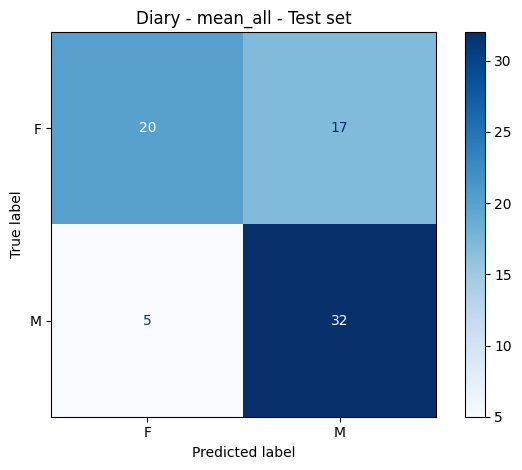

In [9]:
mask = np.isin(y_test, ["M", "F"])
X_test_filtered = X_test[mask]
y_test_filtered = y_test[mask]
test_ids_filtered = np.array(test_ids)[mask]

clf = LinearSVC(random_state=0, max_iter=5000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test_filtered)

test_acc = accuracy_score(y_test_filtered, y_pred)
print(f"\nAccuracy sul test set con la strategia migliore ({best_strategy}): {test_acc:.4f}")

cm = confusion_matrix(y_test_filtered, y_pred, labels=["F", "M"])
print("\nConfusion matrix (F/M):\n", cm)

print("\nClassification report:")
print(classification_report(y_test_filtered, y_pred, digits=4))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["F", "M"])
disp.plot(cmap="Blues")
plt.title(f"{genre.capitalize()} - {best_strategy} - Test set")
plt.grid(False)
plt.tight_layout()
plt.show()

## Confronto con dummy classifier

In [11]:
from sklearn.dummy import DummyClassifier

# Addestramento
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

# Valutazione
y_dummy_pred = dummy.predict(X_test_filtered)
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
print("Accuracy Dummy:", accuracy_score(y_test_filtered, y_dummy_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_filtered, y_dummy_pred))
print("Classification Report:\n", classification_report(y_test_filtered, y_dummy_pred))

Accuracy Dummy: 0.5
Confusion Matrix:
 [[37  0]
 [37  0]]
Classification Report:
               precision    recall  f1-score   support

           F       0.50      1.00      0.67        37
           M       0.00      0.00      0.00        37

    accuracy                           0.50        74
   macro avg       0.25      0.50      0.33        74
weighted avg       0.25      0.50      0.33        74



C:\Users\agnes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\agnes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\agnes\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo